In [15]:
import numpy as np
import matplotlib.pyplot as plt

In [16]:
# parameter choice definitions

def CRR(r: float, sigma: float, T: float, nsteps: int) -> list:
    dt = T/nsteps
    sdt = np.sqrt(dt)
    nu = r-0.5*sigma**2
    u = np.exp(nu*dt + sigma*sdt)
    d = np.exp(nu*dt - sigma*sdt)
    p = 1/2
    #print((np.exp(r*dt)-d)/(u-d))

    return ([u, d, p])

def JD(r: float, sigma: float, T: float, nsteps: int) -> list:
    dt = T/nsteps
    sdt = np.sqrt(dt)
    nu = r-0.5*sigma**2
    u = np.exp(sigma*sdt)
    d = np.exp(-sigma*sdt)
    p = 0.5*(1 + nu*sdt/sigma)
    #print((np.exp(r*dt)-d)/(u-d))

    return ([u, d, p])

def EQP(r: float, sigma: float, T: float, nsteps: int) -> list:
    dt = T/nsteps
    sdt = np.sqrt(dt)
    nu = r-0.5*sigma**2
    u = np.exp(0.5*nu*dt + sigma*sdt)
    d = np.exp(1.5*nu*dt - sigma*sdt)
    p = 1/2
    #print((np.exp(r*dt)-d)/(u-d))

    return ([u, d, p])

def TRG(r: float, sigma: float, T: float, nsteps: int) -> list:
    dt = T/nsteps
    sdt = np.sqrt(dt)
    nu = r-0.5*sigma**2
    dx = np.sqrt(sigma**2*dt + (nu*dt)**2)
    u = np.exp(dx)
    d = np.exp(-dx)
    p = 0.5*(1 + nu*dt/dx)
    #print((np.exp(r*dt)-d)/(u-d))

    return ([u, d, p])


### Additive Binomial Model ###
The (additive) binomial asset price model specifies that in an interval $\Delta t$ the log of asset price $x(=\ln{S})$ can only go up by $\Delta_{u}$ or down by $\Delta_{d}$.

Each $(i,j)$ in the model represents a node at time step $i$ having $j$ upward movements where $i \in [0,N]$ and $j \in [0,i]$.

$$
S_{i,j}=\exp{x_{i,j}}=\exp{(x_{0} + j\Delta_{u} + (i-j)\Delta_{d})}
$$

Computation of the option price by backward propagation remains same as the (multiplicative) binomial model.

In [17]:
def aBM_Euro(S0: float, K: float, r: float, sigma: float, T: float, Ntree: int, optype: str, mode: callable = TRG) -> float:
    '''
    S0: initial asset price
    K: strike price
    r: risk-free rate
    sigma: volatility
    T: time to maturity
    Ntree: number of periods
    optype: option type ('call' or 'put')
    mode: parameter choice ('CRR', 'JD', 'EQP', 'TRG')
    '''
    if mode not in [CRR, JD, EQP, TRG]:
        raise Exception('mode not defined')
    else:
        pass

    dt = T/Ntree
    dfact = np.exp(-r*dt) # discount factor    

    params = mode(r=r, sigma=sigma, T=T, nsteps=Ntree)
    u = params[0]
    d = params[1]
    p = params[2] # risk neutral probability of up move

    lnu = np.log(u) # log change up
    lnd = np.log(d) # log change down
    
    # parameter exception
    if ((0<r) and (0<sigma)):
        pass
    else:
        raise Exception('parameter values not allowed')

    #payoff matrix
    Pmat = np.zeros(shape=(Ntree+1,Ntree+1))
    Pmat[Ntree, 0] = S0
    for t in range (Ntree+1): # asset price
        exponents = np.arange(t+1)
        Pmat[Ntree-t:,t] = S0*np.exp((lnu*exponents[::-1])+(lnd*exponents))
    Kmat = K*np.fliplr(np.tri(Ntree+1)) # strike
    Pmat = Pmat-Kmat

    if optype == 'call':
        Pmat[Pmat<0] = 0
        Pmat = Pmat
    elif optype == 'put':
        Pmat[Pmat>0] = 0
        Pmat = -Pmat
    else: raise Exception('optype must be call or put')

    # payoff at maturity T
    Vmat = np.zeros(shape=(Ntree+1,Ntree+1))
    Vmat[:,-1] = Pmat[:,-1]

    # backward step wise option price calculation
    for m, t in enumerate(range(Ntree-1,-1,-1)):
        Vmat[m+1:, t] = dfact*(p*Vmat[m:Ntree, t+1] + (1-p)*Vmat[m+1:, t+1]) 
    return (Vmat)    

In [18]:
price=aBM_Euro(S0=100, K=100, r=0.06, sigma=0.2, T=1, Ntree=3, optype='call')
print(np.around(price,3))

[[ 0.     0.     0.    41.724]
 [ 0.     0.    28.143 12.326]
 [ 0.    18.297  6.734  0.   ]
 [11.592  3.679  0.     0.   ]]


In [20]:
def aBM_Amer(S0: float, K: float, r: float, sigma: float, T: float, Ntree: int, optype: str, mode: callable = TRG, exmat: bool = False) -> float:
    '''
    S0: initial asset price
    K: strike price
    r: risk-free rate
    sigma: volatility
    T: time to maturity
    Ntree: number of periods
    optype: option type ('call' or 'put')
    mode: parameter choice ('CRR', 'JD', 'EQP', 'TRG')
    exmat: show early exercise
    '''
    if mode not in [CRR, JD, EQP, TRG]:
        raise Exception('mode not defined')
    else:
        pass
    
    dt = T/Ntree
    dfact = np.exp(-r*dt) # discount factor

    params = mode(r=r, sigma=sigma, T=T, nsteps=Ntree)
    u = params[0]
    d = params[1]
    p = params[2] # risk neutral probability of up move

    lnu = np.log(u) # log change up
    lnd = np.log(d) # log change down
    
    # parameter exception
    if ((0<r) and (0<sigma)):
        pass
    else:
        raise Exception('parameter values not allowed')

    #payoff matrix
    Pmat = np.zeros(shape=(Ntree+1,Ntree+1))
    Pmat[Ntree, 0] = S0
    for t in range (Ntree+1): # asset price
        exponents = np.arange(t+1)
        Pmat[Ntree-t:,t] = S0*np.exp((lnu*exponents[::-1])+(lnd*exponents))
    Kmat = K*np.fliplr(np.tri(Ntree+1)) # strike
    Pmat = Pmat-Kmat

    if optype == 'call':
        Pmat[Pmat<0] = 0
        Pmat = Pmat
    elif optype == 'put':
        Pmat[Pmat>0] = 0
        Pmat = -Pmat
    else: raise Exception('optype must be call or put')

    # payoff at maturity T
    Vmat = np.zeros(shape=(Ntree+1,Ntree+1))
    Vmat[:,-1] = Pmat[:,-1]

    # backward step wise option price calculation
    if exmat == True:
        Exmat = np.zeros(shape=(Ntree+1,Ntree+1))
        for m, t in enumerate(range(Ntree-1,-1,-1)):
            Vmat[m+1:, t] = np.maximum(dfact*(p*Vmat[m:Ntree, t+1] + (1-p)*Vmat[m+1:, t+1]), Pmat[m+1:, t]) # modified for American option
            Exmat[m+1:, t] = (dfact*(p*Vmat[m:Ntree, t+1] + (1-p)*Vmat[m+1:, t+1]) - Pmat[m+1:, t])<0 # early exercise
        plt.matshow(Exmat, cmap=plt.cm.YlGn, aspect=0.5 )
        plt.title('Early exercise')
    if exmat == False:
        for m, t in enumerate(range(Ntree-1,-1,-1)):
            Vmat[m+1:, t] = np.maximum(dfact*(p*Vmat[m:Ntree, t+1] + (1-p)*Vmat[m+1:, t+1]), Pmat[m+1:, t]) # modified for American option

    return (Vmat)

[[ 0.     0.     0.    -0.   ]
 [ 0.     0.    -0.    -0.   ]
 [ 0.     2.066  4.761 10.974]
 [ 6.162 11.601 20.743 29.44 ]]


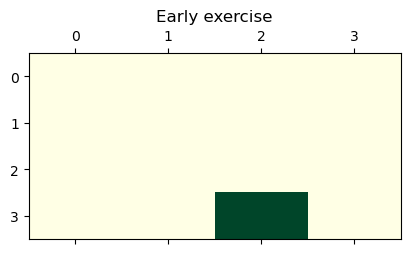

In [21]:
price=aBM_Amer(S0=100, K=100, r=0.06, sigma=0.2, T=1, Ntree=3, optype='put', exmat=True)
print(np.around(price,3))